Tema: Simulação de Tráfego e Mobilidade Urbana. 

 A simulação de tráfego e mobilidade urbana é um campo de estudo que se concentra em modelar e prever o movimento dos veículos em ambientes urbanos. Este campo permite-nos analisar como diferentes políticas de trânsito podem impactar na eficiência e na sustentabilidade do sistema de transporte de uma cidade. Através da utilização de técnicas de modelagem computacional avançadas, é possível simular cenários hipotéticos e avaliar os efeitos de intervenções como a implementação de faixas exclusivas de transporte público, restrições de tráfego, expansão de redes de ciclovias e outras medidas de gestão de tráfego. Estas simulações podem fornecer informações valiosas para a tomada de decisões informadas, contribuindo para o planeamento de cidades mais acessíveis, eficientes e sustentáveis.
 
Para tal escolhemos este data set com mais 10.000 ocorrencias de trânsito. o data set localiza-se aqui:https://dados.cm-lisboa.pt/en/dataset/condicionamentos-de-transito-historico

O principal objetivo é, por exemplo, descobrir se as horas que ocorrem mais condicionamentos, o porquê de existirem e se a duração afeta o impacto.

Grupo nº6: Henrique Ponte, Miguel Carvalho & Miguel Viveiros. 

In [208]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import ast
from shapely.geometry import MultiLineString
import geopandas as gpd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.cluster.hierarchy import dendrogram, linkage


dados = pd.read_csv('transito.csv')

In [209]:
dados.head(10)

,entity_id,impacto,restricao_circulacao,morada,periodos_condicionamentos,motivo,position,creation_date
0,EMEL.condicionamentoTransito.COND-2021-767-1,Relevante,Estreitamento de via,Alto da Boavista/Rotunda Pina Manique/Estrada ...,"[{'end_date': '1616011200000', 'date_min': '20...",OBRA - FAIXA DE RODAGEM,"{'type': 'GeometryCollection', 'geometries': [...",2021-02-04 10:00:09
1,EMEL.condicionamentoTransito.COND-2021-1499-3,Pouco relevante,Estacionamento,"Avenida dos Estados Unidos da América, nº97 e 95","[{'end_date': '1616018400000', 'date_min': '20...",FILMAGENS,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-09 14:44:49
2,EMEL.condicionamentoTransito.COND-2021-1572-A-1,Relevante,Estreitamento de via,Avenida Professor Egas Moniz ft. ao CHULN/HOSP...,"[{'end_date': '1616018400000', 'date_min': '20...",CONCENTRAÇÃO,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-11 12:46:02
3,EMEL.condicionamentoTransito.COND-2021-1499-4,Pouco relevante,Estacionamento,Rua Pereira Henriques entre os nºs 26 - 14,"[{'end_date': '1616018400000', 'date_min': '20...",FILMAGENS,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-09 14:47:00
4,EMEL.condicionamentoTransito.COND-2020-6258-51,Relevante,Corte total,2.ª Circular - entre o IP7 {Eixo N/S} e o ramo...,"[{'end_date': '1616047200000', 'date_min': '20...",REPAVIMENTAÇÕES,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-16 14:33:56
5,EMEL.condicionamentoTransito.COND-2020-2950-PA-24,Relevante,Estreitamento de via,"Praça dos Restauradores,79-80/Rua Jardim do Re...","[{'end_date': '1616054400000', 'date_min': '20...",CARGAS E DESCARGAS/OBRAS,"{'type': 'GeometryCollection', 'geometries': [...",2021-02-22 17:05:34
6,EMEL.condicionamentoTransito.COND-2021-1117-12,Relevante,Mantém perfil de via,Rua do Zaire,"[{'end_date': '1616781600000', 'date_min': '20...",PINTURAS,"{'type': 'GeometryCollection', 'geometries': [...",2021-02-22 14:07:03
7,EMEL.condicionamentoTransito.COND-2021-1117-4,Pouco relevante,Mantém perfil de via,Rua Maria Andrade,"[{'end_date': '1616781600000', 'date_min': '20...",PINTURAS,"{'type': 'GeometryCollection', 'geometries': [...",2021-02-22 13:49:38
8,EMEL.condicionamentoTransito.COND-2021-1662-A-1,Relevante,Passeio,Banco Santander Totta - Banco Santander Totta,"[{'end_date': '1616072400000', 'date_min': '20...",CONCENTRAÇÃO,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-16 10:38:31
9,EMEL.condicionamentoTransito.COND-2021-1622-1,Relevante,Estreitamento de via,"Praça da Constituição de 1976, Frente à Assemb...","[{'end_date': '1616090400000', 'date_min': '20...",CONCENTRAÇÃO,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-15 09:36:38


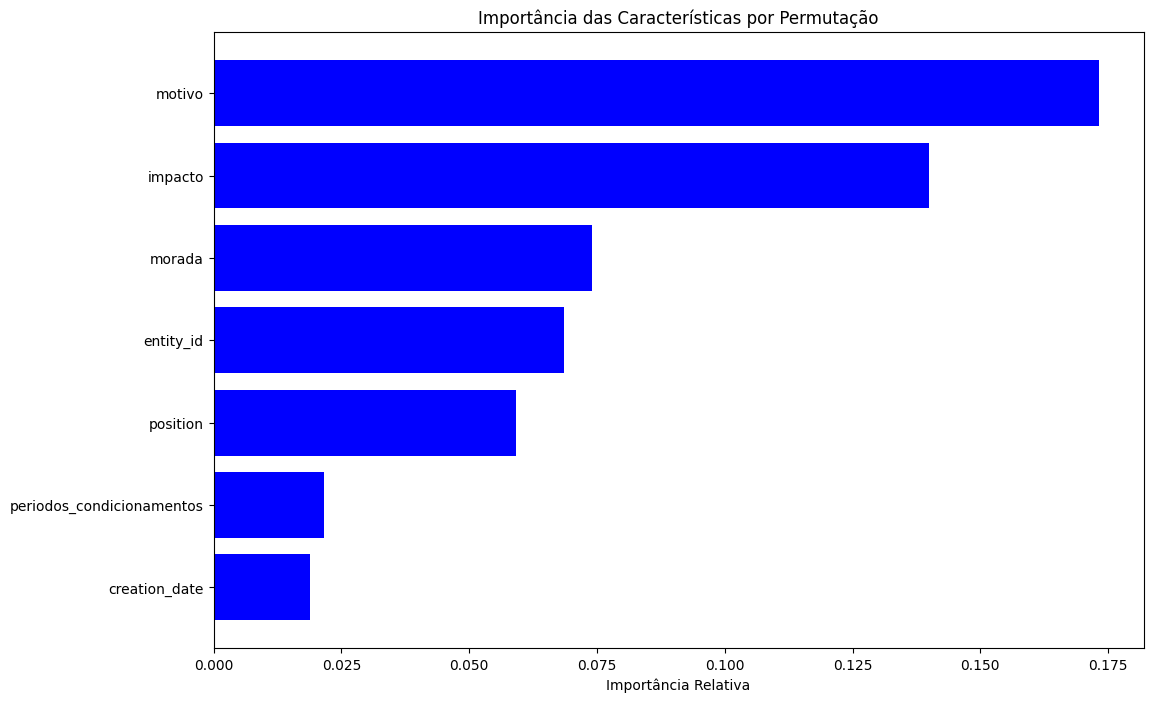

In [210]:
# Codificar as características categóricas usamos o Label enconder
encoders = {}
for col in dados.columns:
    if dados[col].dtype == 'object':
        dados[col] = dados[col].astype(str)
        
        le = LabelEncoder()
        dados[col] = le.fit_transform(dados[col])
        encoders[col] = le


coluna_alvo = 'restricao_circulacao'

# Separar as características e o alvo
X = dados.drop(coluna_alvo, axis=1)
y = dados[coluna_alvo]

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar um modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Calcule a importância das características por permutação
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Obtenha a importância das características e os nomes das características
importances = result.importances_mean
feature_names = X_test.columns.tolist()

# Ordene as características pela importância
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title("Importância das Características por Permutação")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importância Relativa')
plt.show()



Os dados recolhidos apresentam 8 colunas. Com a seguinte informação:
- entity_id
  - Informação que guarda: Refere-se ao identificador do condicionamento
  - Escala de medida: Escala Nominal
  - Unidade: N/A

- impacto
  - Informação que guarda: Refere-se ao nível de impacto na circulação (por exemplo, "Pouco relevante")
  - Escala de medida: Escala Ordinal
  - Unidade: N/A

- restricao_circulacao
  - Informação que guarda: Refere-se ao tipo de restrição à circulação (por exemplo, "Estacionamento")
  - Escala de medida: Escala Nominal
  - Unidade: N/A

- morada
  - Informação que guarda: Refere-se à morada do condicionamento
  - Escala de medida: Escala Nominal
  - Unidade: N/A

- periodos_condicionamentos
  - Informação que guarda: Refere-se à data de início e data de fim do condicionamento
  - Escala de medida: Escala de Intervalo
  - Unidade: Milissegundos desde a época Unix (1 de janeiro de 1970)

- motivo
  - Informação que guarda: Refere-se ao motivo do condicionamento (por exemplo, "FILMAGENS")
  - Escala de medida: Escala Nominal
  - Unidade: N/A

- position
  - Informação que guarda: Refere-se às coordenadas (latitude/longitude)
  - Escala de medida: Escala de Rácios
  - Unidade: Graus

- creation_date
  - Informação que guarda: Refere-se à data em que o condicionamento foi registado
  - Escala de medida: Escala de Intervalo
  - Unidade: Data e hora

PRÉ-PROCESSAMENTO

O pré-processamento de dados é uma etapa essencial na análise de dados e machine learning que inclui:

1. Limpeza de dados: Trata dados em falta e ruído.
2. Transformação de dados: Melhora a eficácia dos algoritmos de mineração de dados.
3. Redução de dados: Remove dados redundantes ou irrelevantes.

A escolha das técnicas depende do conjunto de dados e do problema a ser resolvido. O pré-processamento pode ser aplicado a dados estruturados, semiestruturados e não estruturados. É uma etapa que melhora a qualidade dos dados, levando a resultados mais precisos e confiáveis.

Para além da remoção dos outliers removemos as seguintes colunas entity_id e creation_date porque as mesmas não sao relevantes para a nossa análise


In [211]:
# Remover as colunas menos relevantes
dados = dados.drop(['entity_id', 'creation_date'], axis=1)

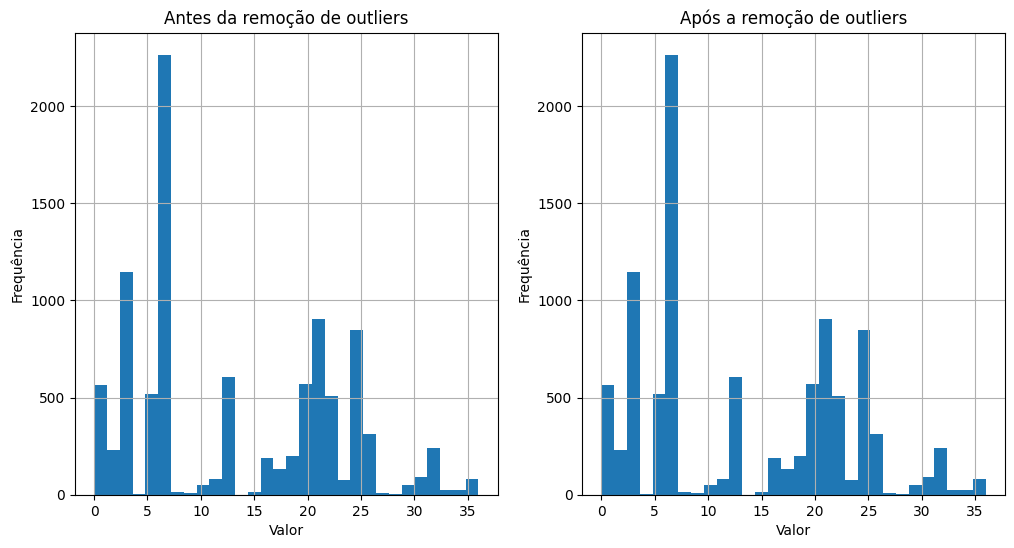

In [212]:
coluna = 'motivo'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


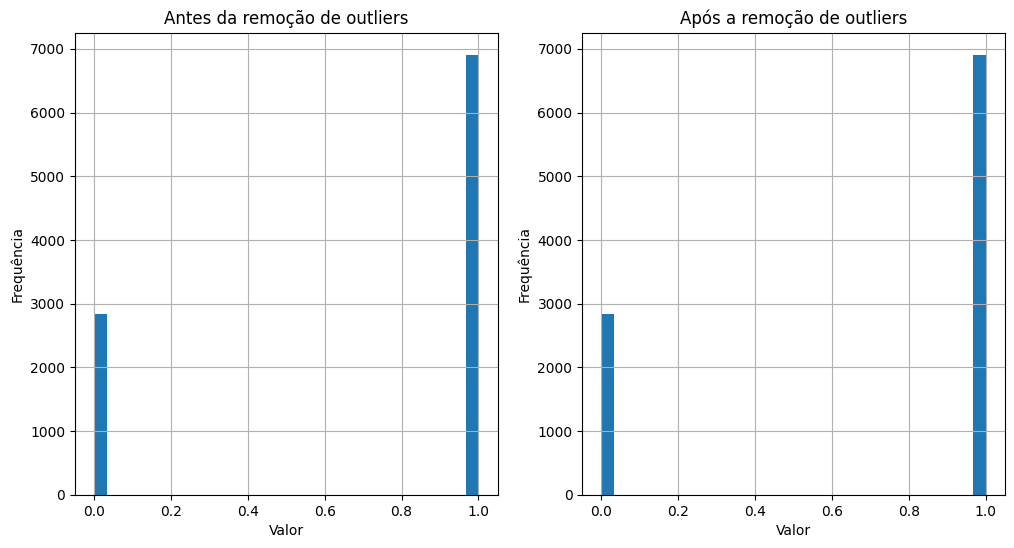

In [213]:
coluna = 'impacto'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


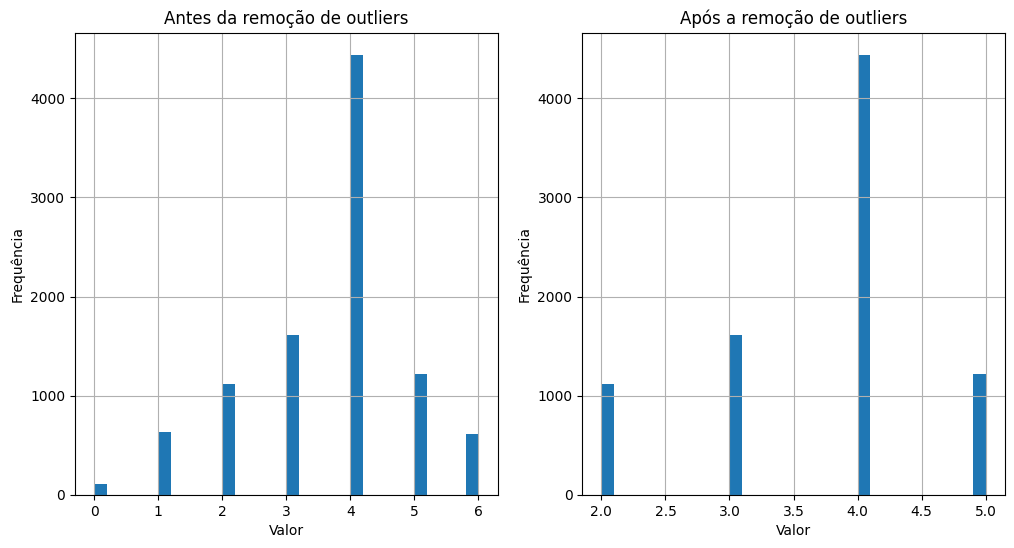

In [214]:
coluna = 'restricao_circulacao'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


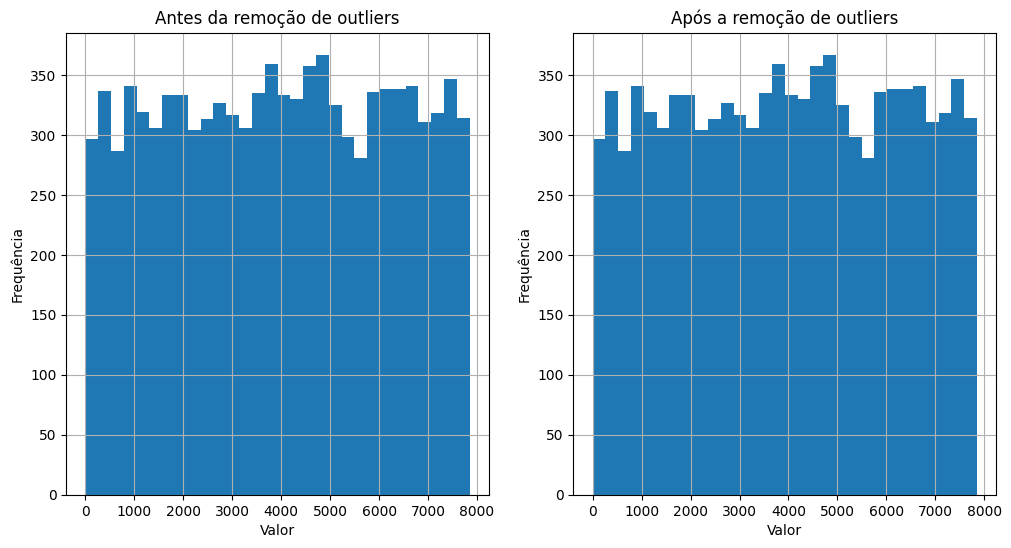

In [215]:
coluna = 'position'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


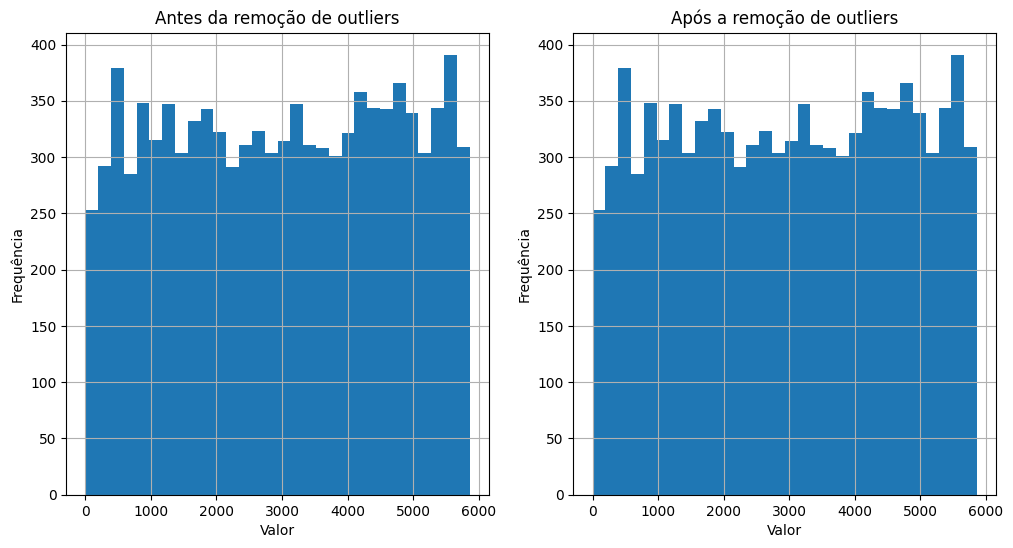

In [216]:
coluna = 'periodos_condicionamentos'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


Após o tratamento dos dados inciamos por fazer alguns graficos relacionando as nossas colunas a procura de padrões e relações.

In [217]:
# Agora, para decodificar como queremos que mostre os dados categoricos e não em números
for col in dados.columns:
    if col in encoders:
        dados[col] = encoders[col].inverse_transform(dados[col])


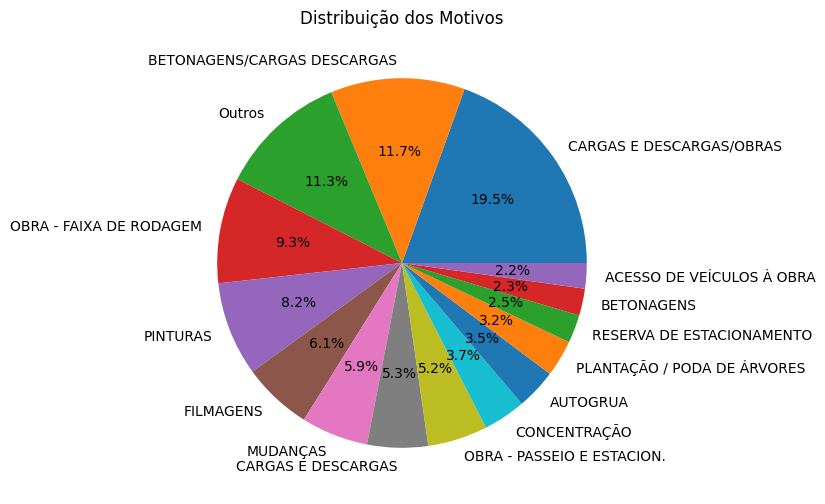

In [218]:
contagem_motivos = dados['motivo'].value_counts()

porcentagem_motivos = 100 * contagem_motivos / contagem_motivos.sum()

outros = porcentagem_motivos < 2

dados['motivo'] = dados['motivo'].where(~dados['motivo'].isin(porcentagem_motivos.index[outros]), 'Outros')

# Contar a frequência dos motivos novamente
contagem_motivos = dados['motivo'].value_counts()

# Criar o gráfico circular
plt.figure(figsize=(10, 6))
plt.pie(contagem_motivos, labels = contagem_motivos.index, autopct='%1.1f%%')
plt.title('Distribuição dos Motivos')
plt.show()

fig = px.pie(dados, names='motivo', title='Distribuição dos Motivos')
fig.show()

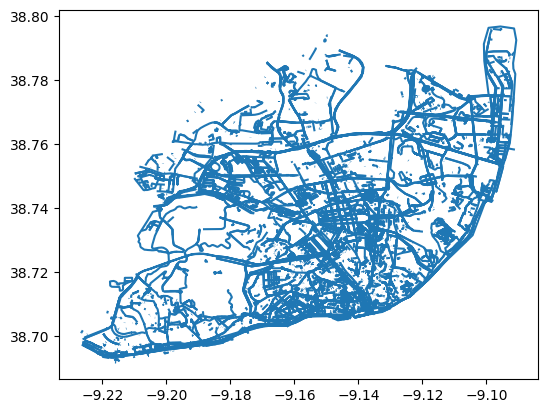

In [219]:
# Converter a coluna 'position' de string para um objeto Python (dicionário)
dados['position'] = dados['position'].apply(ast.literal_eval)

# Criar uma GeoDataFrame a partir das geometrias
gdf = gpd.GeoDataFrame(dados, geometry=[MultiLineString(geom['geometries'][0]['coordinates']) for geom in dados['position']])

# Visualizar as geometrias
gdf.plot()
plt.show()

1. Converte uma coluna de ‘strings’ para um dicionário.
2. Cria um GeoDataFrame usando as geometrias extraídas dessa coluna.
3. Visualiza essas geometrias num gráfico.

A imagem que acompanha o código é um gráfico de dados geográficos, representando estradas de lisboa.

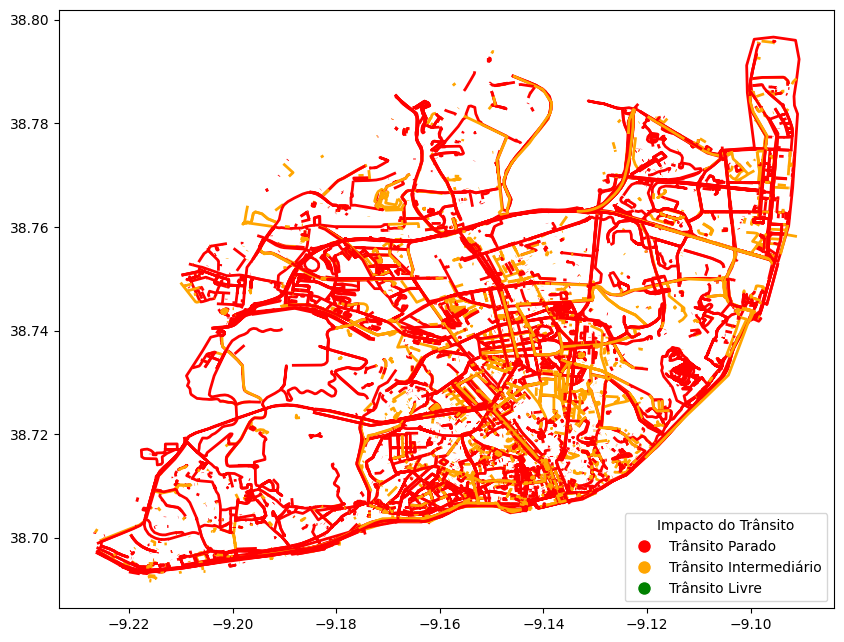

In [220]:
# Criação de GeoDataFrame
gdf = gpd.GeoDataFrame(dados, geometry=[MultiLineString(geom['geometries'][0]['coordinates']) for geom in dados['position']])

# Mapeamento de Cores
colors = {'Relevante': 'red', 'Pouco relevante': 'orange', 'Livre': 'green'}

# Adicionando uma coluna de cores com base no impacto do trânsito
gdf['color'] = dados['impacto'].map(colors)

# Visualização com Cores
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], linewidth=2)

# Adicionando uma legenda
legend_labels = {'Relevante': 'Trânsito Parado', 'Pouco relevante': 'Trânsito Intermediário', 'Livre': 'Trânsito Livre'}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[impacto], markersize=10, label=label) for impacto, label in legend_labels.items()]
ax.legend(handles=legend_handles, title='Impacto do Trânsito', loc='lower right')

plt.show()

1. Cria um GeoDataFrame com base nas geometrias extraídas de uma coluna de dados.
2. Mapeia cores para diferentes níveis de impacto do trânsito.
3. Adiciona uma coluna de cores ao GeoDataFrame com base no impacto do trânsito.
4. Visualiza os dados num gráfico, com as cores indicando o impacto do trânsito.
5. Adiciona uma legenda ao gráfico para explicar o significado das cores.

A imagem que acompanha o código é um mapa que mostra as condições de trânsito em lisboa, com diferentes cores indicando diferentes níveis de impacto do trânsito. 

Importante notar que nao aparece verde porque no nosso data set legend_labels = {'Relevante': 'Trânsito Parado', 'Pouco relevante': 'Trânsito Intermediário', 'Livre': 'Trânsito Livre'} a cor verde correspondente ao livre está definido por uma variavel Trânsito Livre que nao existe no nosso data set mas podera ser futuramente introduzido.

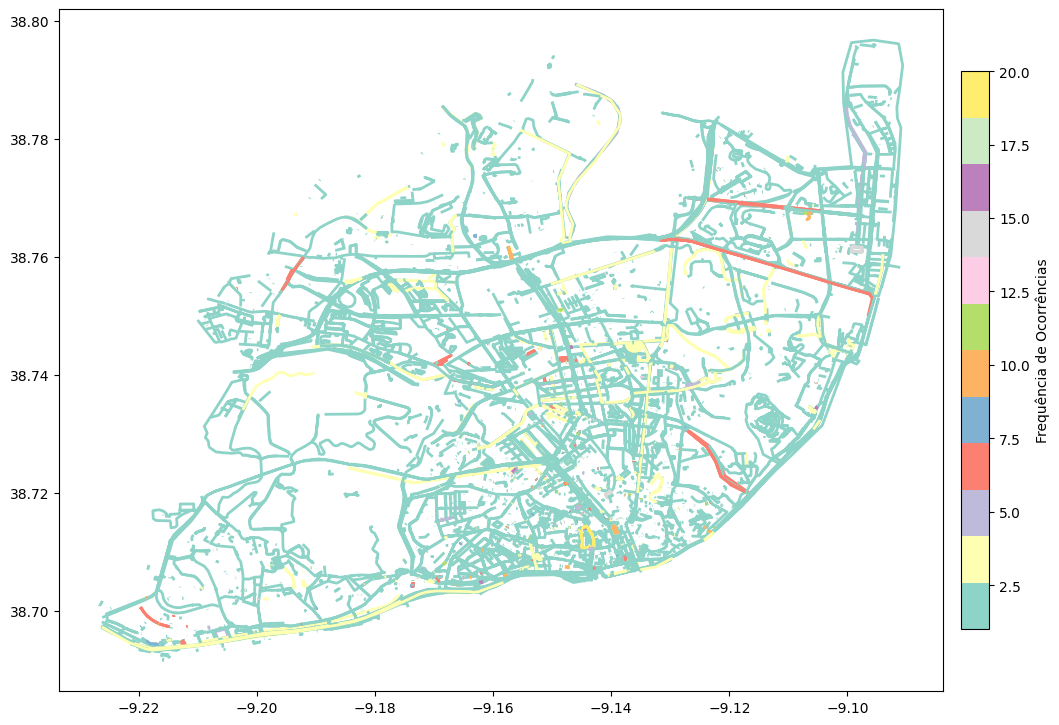

In [221]:
# Criação de GeoDataFrame
gdf = gpd.GeoDataFrame(dados, geometry=[MultiLineString(geom['geometries'][0]['coordinates']) for geom in dados['position']])

# Contar a frequência de cada morada
contagem_moradas = dados['morada'].value_counts()

# Normalizar a escala de cores com base na frequência
norm = Normalize(vmin=min(contagem_moradas), vmax=max(contagem_moradas))
mapper = ScalarMappable(norm=norm, cmap='Set3')

# Adicionando uma coluna de cores com base na frequência de ocorrências
gdf['color'] = dados['morada'].map(lambda x: mapper.to_rgba(contagem_moradas[x]))

# Visualização com Cores
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, color=gdf['color'], linewidth=2)

# Adicionando uma barra de cores
cbar = fig.colorbar(mapper, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
cbar.set_label('Frequência de Ocorrências')

plt.show()


1. Criação de GeoDataFrame: Um GeoDataFrame é criado a partir de dados existentes, onde a coluna de geometria é preenchida com objetos MultiLineString. Esses objetos representam as coordenadas geográficas de diferentes localizações.

2. Contagem de Frequência de Endereços: A frequência de cada endereço nos dados é contada.

3. Normalização de Cor: Uma escala de cores é normalizada com base na frequência dos endereços. Isso é feito usando a função `Normalize` do Matplotlib, que escala os valores de entrada para o intervalo de 0-1.

4. Adição de Coluna de Cor: Uma nova coluna 'color' é adicionada ao GeoDataFrame. Cada endereço é mapeado para uma cor com base na sua frequência de ocorrência.

5. Visualização: O GeoDataFrame é plotado como um mapa, onde a cor de cada linha (representando um endereço) corresponde à sua frequência de ocorrência. O parâmetro linewidth é definido como 2, tornando as linhas duas vezes mais espessas que o padrão.

6. Adição de Barra de Cores: Uma barra de cores é adicionada ao gráfico, que serve como uma legenda para as frequências codificadas por cores. O rótulo da barra de cores é definido como 'Frequência de Ocorrências'.

A imagem, mostra o mapa geográfico de lisboa com linhas de diferentes cores representando a frequência de ocorrências de diferentes endereços. A barra de cores à direita indica a escala de frequência.


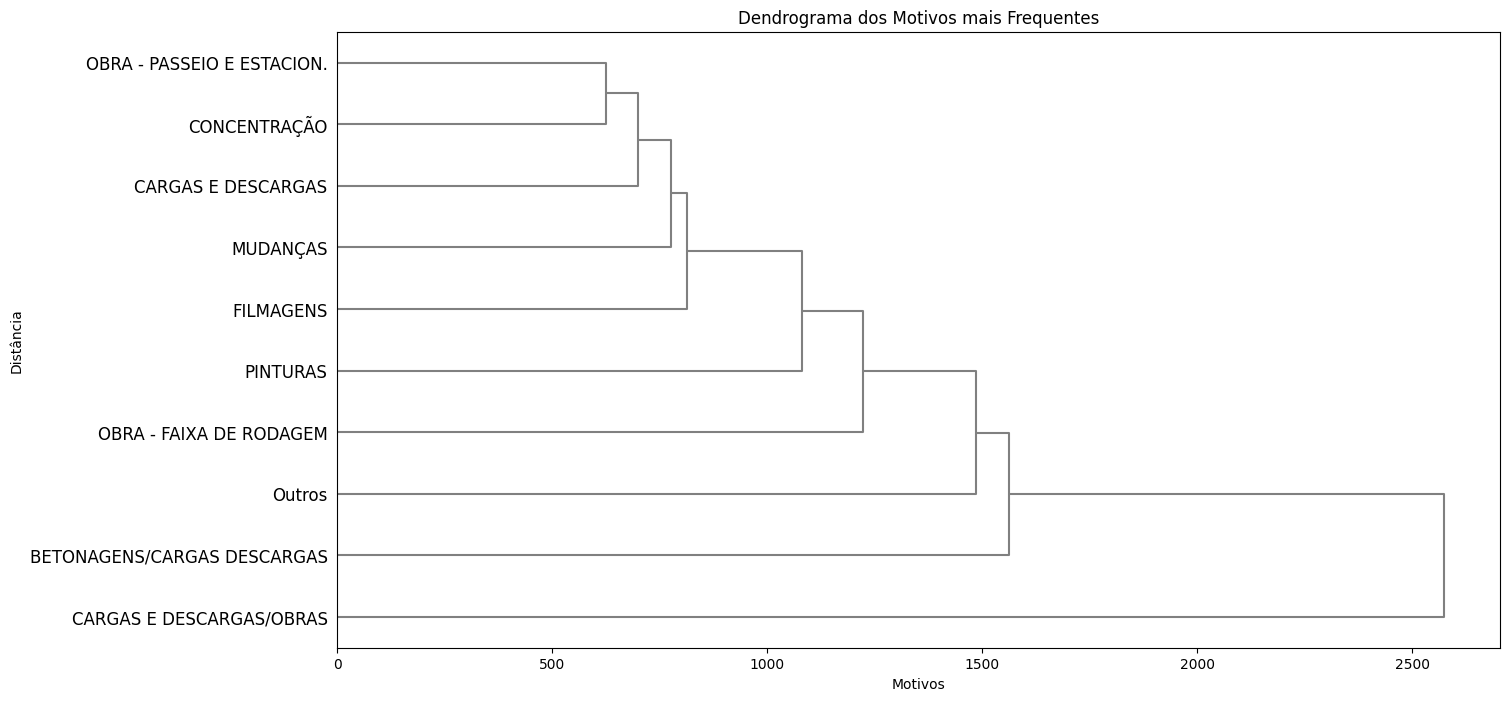

In [222]:
# Contagem da frequência de cada motivo
contagem_motivos = dados['motivo'].value_counts()

# Selecionar os 10 motivos mais frequentes
top_motivos = contagem_motivos.nlargest(10)

# Filtrar o DataFrame para incluir apenas os 10 motivos mais frequentes
df_top_motivos = dados[dados['motivo'].isin(top_motivos.index)]

# Criar matriz de distância para o agrupamento hierárquico
dist_matrix = pd.crosstab(df_top_motivos['motivo'], df_top_motivos['motivo'])

# Realizar agrupamento hierárquico
linkage_matrix = linkage(dist_matrix, method='ward')

# Plotar o dendrograma
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=dist_matrix.index, orientation="right", color_threshold=0,
           above_threshold_color='grey')

plt.title('Dendrograma dos Motivos mais Frequentes')
plt.xlabel('Motivos')
plt.ylabel('Distância')
plt.show()

**Dendograma**
O código fornecido é usado para realizar o agrupamento hierárquico dos motivos mais frequentes encontrados num conjunto de dados. Aqui está um resumo:

1. Contagem da Frequência de Cada Motivo: A frequência de cada motivo no conjunto de dados é contada.

2. Seleção dos 10 Motivos Mais Frequentes: Os 10 motivos mais frequentes são selecionados.

3. Filtragem do DataFrame: O DataFrame original é filtrado para incluir apenas as linhas correspondentes a estes 10 motivos mais frequentes.

4. Criação da Matriz de Distância: Uma matriz de distância é criada usando uma tabulação cruzada dos motivos contra eles mesmos.

5. Realização do Agrupamento Hierárquico: O agrupamento hierárquico é realizado usando o método de Ward, que minimiza a variância total dentro do cluster.

6. Plotagem do Dendrograma: Finalmente, é plotado um dendrograma visualizando o quão relacionados estão esses motivos principais, com base na sua ocorrência no conjunto de dados. O eixo x representa os motivos e o eixo y representa a distância.

A imagem, mostra um dendrograma que representa o agrupamento hierárquico de vários motivos. Existem vários clusters formados em diferentes distâncias, indicando níveis variáveis de similaridade entre motivos como "OBRA - PASSEIO E ESTACION.", "CONCENTRAÇÃO", "CARGAS E DESCARGAS", etc.

In [222]:
#grafico de cotovelo


#explicação

Mais graficos ...etc

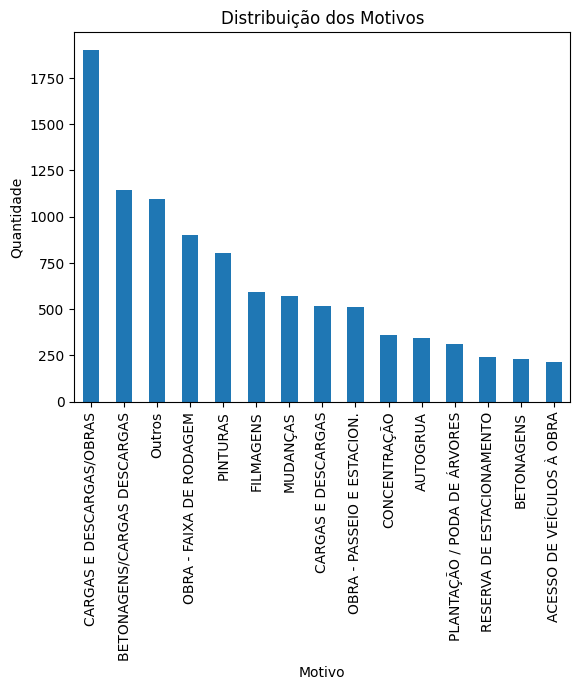

In [223]:
dados['motivo'].value_counts().plot(kind='bar')
plt.title('Distribuição dos Motivos')
plt.xlabel('Motivo')
plt.ylabel('Quantidade')
plt.show()

1. Contagem da Frequência de Cada Motivo: A frequência de cada motivo no conjunto de dados é contada.

2. Visualização: A distribuição dos motivos é visualizada como um gráfico de barras. O eixo x representa diferentes motivos e o eixo y representa as suas quantidades. Um título, rótulo do eixo x e rótulo do eixo y são adicionados para tornar o gráfico mais informativo.

A imagem, mostra o gráfico de barras que representa a distribuição dos motivos. Cada barra representa a contagem de cada motivo com "CARGAS E DESCARGAS" tendo a contagem mais alta, seguido por "BETONEIRAS", e assim por diante. As barras são exibidas em ordem decrescente das suas contagens.


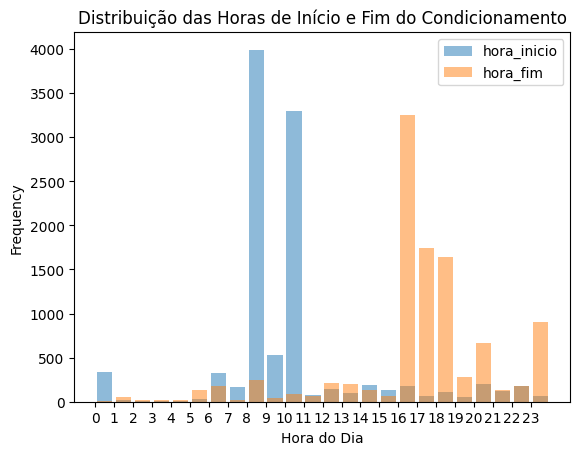

In [224]:
# Extrair as horas de início e fim do condicionamento
dados['hora_inicio_condicionamento'] = dados['periodos_condicionamentos'].apply(lambda x: [i['hour_min'] for i in ast.literal_eval(x)])
dados['hora_fim_condicionamento'] = dados['periodos_condicionamentos'].apply(lambda x: [i['hour_max'] for i in ast.literal_eval(x)])

# Converter as horas para um formato numérico (por exemplo, "08:00:00" se torna 8.0)
dados['hora_inicio_condicionamento'] = dados['hora_inicio_condicionamento'].apply(lambda x: [float(i.split(':')[0]) + float(i.split(':')[1])/60 for i in x])
dados['hora_fim_condicionamento'] = dados['hora_fim_condicionamento'].apply(lambda x: [float(i.split(':')[0]) + float(i.split(':')[1])/60 for i in x])

horas_condicionamento = pd.DataFrame({'hora_inicio': [hora for sublist in dados['hora_inicio_condicionamento'] for hora in sublist],
                                      'hora_fim': [hora for sublist in dados['hora_fim_condicionamento'] for hora in sublist]})

# Plotar um histograma das horas de início e fim do condicionamento
horas_condicionamento[['hora_inicio', 'hora_fim']].plot(kind='hist', rwidth=0.8, alpha=0.5, bins=24)
plt.title('Distribuição das Horas de Início e Fim do Condicionamento')
plt.xlabel('Hora do Dia')
plt.xticks(range(24))
plt.show()

1. Extração das Horas de Início e Fim do Condicionamento: As horas de início e fim do condicionamento são extraídas do campo 'periodos_condicionamentos' do conjunto de dados. Isso é feito aplicando uma função lambda que extrai 'hour_min' e 'hour_max' para cada entrada.

2. Conversão das Horas para um Formato Numérico: As horas extraídas são convertidas para um formato numérico. Por exemplo, "08:00:00" se torna 8.0. Isso é feito dividindo os minutos por 60 e adicionando ao número de horas.

3. Criação de DataFrame das Horas de Condicionamento: Um novo DataFrame 'horas_condicionamento' é criado com as horas de início e fim do condicionamento.

4. Visualização: Um histograma das horas de início e fim do condicionamento é plotado. O eixo x representa a hora do dia e o eixo y representa a frequência. O gráfico tem 24 bins, representando as 24 horas do dia.

A imagem, mostra um histograma que representa a distribuição das horas de início e fim do condicionamento. A maioria dos eventos de "hora_inicio" ocorre por volta da hora 10, com mais de 3500 ocorrências. A maioria dos eventos de "hora_fim" está distribuída entre as horas 14 e 18, atingindo o pico na hora 16 com mais de 3000 ocorrências.


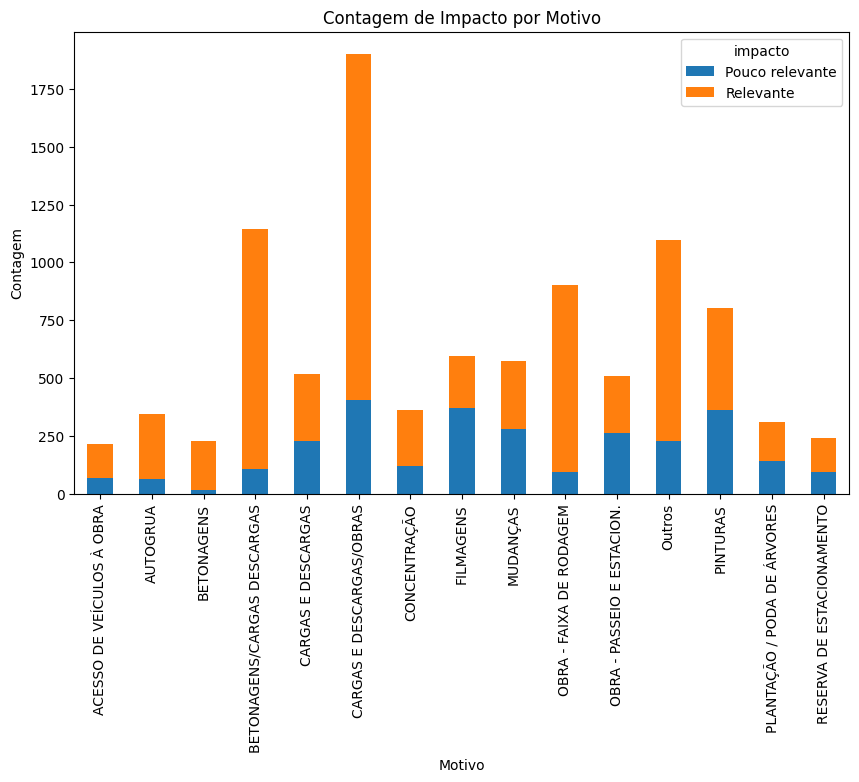

In [225]:
# Contar o número de ocorrências de cada nível de 'impacto' para cada 'motivo'
contagem_impacto_por_motivo = dados.groupby('motivo')['impacto'].value_counts().unstack()

# Criar um gráfico de barras empilhadas
contagem_impacto_por_motivo.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Contagem de Impacto por Motivo')
plt.xlabel('Motivo')
plt.ylabel('Contagem')
plt.show()

1. Contagem de Impacto por Motivo: O número de ocorrências de cada nível de 'impacto' para cada 'motivo' é contado. Isso é feito agrupando o DataFrame 'dados' por 'motivo' e contando o número de ocorrências de cada valor de 'impacto'. O resultado é um novo DataFrame onde cada linha corresponde a um 'motivo' e cada coluna corresponde a um nível de 'impacto'.

2. Criação de um Gráfico de Barras Empilhadas: Um gráfico de barras empilhadas é criado a partir do DataFrame 'contagem_impacto_por_motivo'. Cada barra no gráfico representa um 'motivo' e é dividida em seções coloridas que representam diferentes níveis de 'impacto'. A altura de cada seção colorida corresponde ao número de ocorrências do respetivo nível de 'impacto' para o 'motivo' correspondente.

A imagem, mostra um gráfico de barras empilhadas que representa a contagem de impacto por motivo. Cada barra no gráfico representa um motivo sendo dividida em seções coloridas que representam diferentes níveis de impacto. A altura de cada seção colorida corresponde ao número de ocorrências do respetivo nível de impacto para o motivo correspondente.
